# Crime Trends Analysis Tool v1.0

The Crime Trends Analysis Tool analyzes citywide crime trends and surfaces problematic crime conditions, enabling commanders to begin problem-solving immediately.

In [1]:
import datetime as dt
import os.path
import urllib.request
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

## Loading Data & Cleaning
For the purposes of this demo, you can download NYPD's open data below (recommended) or load in your own data (instructions below).

### Example with NYPD Open Data

In [3]:
# Download CSV files with historic crime data and save to current directory 
# Note: this may take 10+ minutes based on connection speed

if not os.path.isfile('NYPD-Complaint-Date_Current-YTD.csv'):
    print ('Downloading: NYPD-Complaint-Date_Current-YTD.csv') # size ~60MB
    urllib.request.urlretrieve('https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD', 
                               'NYPD-Complaint-Date_Current-YTD.csv')

if not os.path.isfile('NYPD-Complaint-Data-Historic.csv'):
    print ('Downloading: NYPD-Complaint-Data-Historic.csv') #size ~1.43GB
    urllib.request.urlretrieve('https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD', 
                               'NYPD-Complaint-Data-Historic.csv')

In [4]:
# Combine the historical complaint data with the current YTD complaint data
dfs = []
use_cols = ['CMPLNT_NUM', 'RPT_DT', 'ADDR_PCT_CD', 'OFNS_DESC']
files = ['NYPD-Complaint-Date_Current-YTD.csv', 'NYPD-Complaint-Data-Historic.csv']
for fn in files:
    print ('Reading data from:', fn)
    df = pd.read_csv(fn, usecols=use_cols)
    dfs.append(df)

crimes = pd.concat(dfs, ignore_index=True, axis=0)
del dfs

# Data cleaning, reducing memory usage
crimes['RPT_DT'] = pd.to_datetime(crimes['RPT_DT'], format='%m/%d/%Y', errors='coerce')
crimes['OFNS_DESC'] = crimes['OFNS_DESC'].astype('category')
crimes = crimes.dropna()
crimes['ADDR_PCT_CD'] = pd.to_numeric(crimes['ADDR_PCT_CD'], downcast='unsigned')
crimes = crimes[['CMPLNT_NUM', 'RPT_DT', 'ADDR_PCT_CD', 'OFNS_DESC']]
crimes.columns = ['id', 'date', 'pct', 'crime']

Reading data from: NYPD-Complaint-Date_Current-YTD.csv
Reading data from: NYPD-Complaint-Data-Historic.csv


In [5]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5788105 entries, 0 to 5807405
Data columns (total 4 columns):
id       int64
date     datetime64[ns]
pct      uint8
crime    category
dtypes: category(1), datetime64[ns](1), int64(1), uint8(1)
memory usage: 143.5 MB


In [6]:
crimes.head()

,id,date,pct,crime
0,417734073,2017-06-30,90,CRIMINAL MISCHIEF & RELATED OF
1,433995840,2017-06-30,32,HARRASSMENT 2
2,641950009,2017-06-30,73,DANGEROUS DRUGS
3,220585856,2017-06-30,9,ROBBERY
4,272762078,2017-06-30,47,HARRASSMENT 2


### Load your own Department data
To load in your own data, create a CSV file with incident-level data containing the following 4 columns:
* **`id`**: a report number for an incident
* **`date`**: date incident occurred or was reported, depending on how you want to evaluate trends
* **`pct`**: precinct/district/sector where incident occurred (but column must be called "pct")
* **`crime`**: crime type (this could be FBI UCR, a specific charge, or internal crime designation, etc.)

Remove the comments from the code cell below and replace `example.csv` with the path to your CSV file.

In [7]:
# crimes = pd.read_csv('example.csv', # replace with path to file
#                      dtype={'crime': 'category'})
# crimes['date'] = pd.to_datetime(crimes['date'], errors='coerce')
# crimes.dropna() # no null values can be accepted. Fix any bad/null values before importing data.

In [8]:
# crimes.info()

In [9]:
# crimes.head()

### User-defined Constants

* **`YEARS_TO_ANALYZE`**: Number of years to generate trend data for (default: 1 year)
* **`REPORT_DATE`**: Ending date to generate trend data (note: must be a Sunday to align with NYPD reporting periods)

In [10]:
# Number of years of historical trends to generate, change as desired (recommend 0 or 1)
YEARS_TO_ANALYZE = 1

In [11]:
# For this purposes of this report, the weekly crime reporting period is Monday - Sunday. So,
# we need to find the last Sunday in the dataset.
max_date = crimes['date'].max().to_pydatetime()
idx = (max_date.weekday() + 1) % 7
last_sunday = max_date - dt.timedelta(7+idx)

REPORT_END_DT = last_sunday

REPORT_START_DT = REPORT_END_DT - relativedelta(weeks=52 * YEARS_TO_ANALYZE) - relativedelta(weeks=55, days=6)

DATA_START_DT = dt.datetime(REPORT_START_DT.year, 1, 1) # necessary for calculating YTD counts

In [12]:
print('Report Date:', REPORT_END_DT.strftime('%Y-%m-%d'))
print('Data Start Date:', DATA_START_DT.strftime('%Y-%m-%d'))

Report Date: 2017-06-18
Data Start Date: 2015-01-01


### Generate trends data

In [13]:
# Filter crime data to only include incidents between the DATA_START_DT and REPORT_END_DT
crimes = crimes.set_index('date').sort_index()
crimes = crimes[DATA_START_DT:REPORT_END_DT]

In [14]:
# Create daily counts of crime types in every precinct
incidents_daily = crimes.groupby(['pct', 'crime'])['id'].resample('D').count()

In [15]:
incidents_daily.head(10)

pct  crime                date      
1    ADMINISTRATIVE CODE  2015-05-04    1
                          2015-05-05    0
                          2015-05-06    0
                          2015-05-07    0
                          2015-05-08    0
                          2015-05-09    0
                          2015-05-10    0
                          2015-05-11    0
                          2015-05-12    0
                          2015-05-13    0
Name: id, dtype: int64

In [16]:
crimes[(crimes['pct']==1) & (crimes['crime']=='ADMINISTRATIVE CODE')]

,id,pct,crime
date,,,
2015-05-04,258827613,1,ADMINISTRATIVE CODE
2015-08-05,575971008,1,ADMINISTRATIVE CODE
2015-08-05,870337905,1,ADMINISTRATIVE CODE
2015-08-05,188379494,1,ADMINISTRATIVE CODE
2015-08-19,734335061,1,ADMINISTRATIVE CODE
2016-01-13,459508494,1,ADMINISTRATIVE CODE
2016-01-16,174666260,1,ADMINISTRATIVE CODE
2016-04-18,125429514,1,ADMINISTRATIVE CODE
2016-09-24,939716376,1,ADMINISTRATIVE CODE


In [17]:
# Because not every crime occurs at least once every day in each precinct, the daily counts generated above
# start on the date of the first time a particular crime type occurred in the dataset. 
# Here we create a new index to ensure every date has an entry and we will fill days with no crimes 
# with the value of zero

level_0 = incidents_daily.index.get_level_values(0).unique()
level_1 = incidents_daily.index.get_level_values(1).unique()
level_2 = pd.date_range(DATA_START_DT, REPORT_END_DT)
multi_index = pd.MultiIndex.from_product([level_0, level_1, level_2], names=['pct', 'crime', 'date'])

incidents_daily = incidents_daily.reindex(multi_index).fillna(0).astype(int)

In [18]:
incidents_daily.head()

pct  crime                date      
1    ADMINISTRATIVE CODE  2015-01-01    0
                          2015-01-02    0
                          2015-01-03    0
                          2015-01-04    0
                          2015-01-05    0
Name: id, dtype: int64

In [19]:
level_2 = pd.date_range(REPORT_START_DT, REPORT_END_DT)
multi_index = pd.MultiIndex.from_product([level_0, level_1, level_2], names=['pct', 'crime', 'date'])

incidents_daily_rpt = incidents_daily.reindex(multi_index)

In [20]:
incidents_daily_rpt.head()

pct  crime                date      
1    ADMINISTRATIVE CODE  2015-05-25    0
                          2015-05-26    0
                          2015-05-27    0
                          2015-05-28    0
                          2015-05-29    0
Name: id, dtype: int64

In [21]:
# Create weekly counts of incidents
incidents_7_day = (incidents_daily_rpt.unstack(level=[0, 1]) 
                                      .resample('7D', loffset='6D') # add label to ending Sunday
                                      .sum()
                                      .stack(level=[1, 0])
                                      .swaplevel(2,0))
incidents_7_day.name = 'incidents_7_day'

In [22]:
incidents_7_day.head()

pct  crime                date      
1    ADMINISTRATIVE CODE  2015-05-31    0
5    ADMINISTRATIVE CODE  2015-05-31    0
6    ADMINISTRATIVE CODE  2015-05-31    0
7    ADMINISTRATIVE CODE  2015-05-31    0
9    ADMINISTRATIVE CODE  2015-05-31    0
Name: incidents_7_day, dtype: int64

In [23]:
incidents_28_day = (incidents_7_day.groupby(level=['pct', 'crime'])
                                   .rolling(window=4)
                                   .sum()
                                   .dropna()
                                   .astype(int))
incidents_28_day.reset_index(level=[0, 1], drop=True, inplace=True)
incidents_28_day.name = 'incidents_28_day'

In [24]:
incidents_28_day.head()

pct  crime                date      
1    ADMINISTRATIVE CODE  2015-06-21    0
                          2015-06-28    0
                          2015-07-05    0
                          2015-07-12    0
                          2015-07-19    0
Name: incidents_28_day, dtype: int64

In [25]:
# combine the weekly and 28-day counts
incidents = pd.concat([incidents_7_day, incidents_28_day], axis=1, join_axes=[incidents_28_day.index])

In [26]:
incidents.head()

incidents_7_day  incidents_28_day
pct crime               date                                         
1   ADMINISTRATIVE CODE 2015-06-21                0                 0
                        2015-06-28                0                 0
                        2015-07-05                0                 0
                        2015-07-12                0                 0
                        2015-07-19                0                 0

In [27]:
# Calculate the rolling 52 week average and standard deviation
group = incidents.groupby(level=['pct', 'crime'])
incidents['52_week_avg'] = group['incidents_28_day'].rolling(window=52).mean().values
incidents['52_week_std'] = group['incidents_28_day'].rolling(window=52).std().values

In [28]:
len(incidents)

541695

In [29]:
incidents['incidents_28_day_prior_yr'] = group['incidents_28_day'].shift(52).values
incidents['incidents_7_day_prior_yr'] = group['incidents_7_day'].shift(52).values

In [30]:
# Because we shifted 52 weeks, we drop all weeks that now have null values
incidents.dropna(inplace=True)

In [31]:
incidents['incidents_28_day_prior_yr'] = pd.to_numeric(incidents['incidents_28_day_prior_yr'],
                                                       downcast='unsigned')

incidents['incidents_7_day_prior_yr'] = pd.to_numeric(incidents['incidents_7_day_prior_yr'],
                                                      downcast='unsigned')

In [32]:
incidents.head()

incidents_7_day  incidents_28_day  \
pct crime               date                                            
1   ADMINISTRATIVE CODE 2016-06-19                0                 0   
                        2016-06-26                0                 0   
                        2016-07-03                0                 0   
                        2016-07-10                0                 0   
                        2016-07-17                0                 0   

                                    52_week_avg  52_week_std  \
pct crime               date                                   
1   ADMINISTRATIVE CODE 2016-06-19     0.538462     1.056475   
                        2016-06-26     0.538462     1.056475   
                        2016-07-03     0.538462     1.056475   
                        2016-07-10     0.538462     1.056475   
                        2016-07-17     0.538462     1.056475   

                                    incidents_28_day_prior_yr  \
pct crime               date                                    
1   ADMINISTRATIVE CODE 2016-06-19                          0   
                        2016-06-26                          0   
                        2016-07-03                          0   
                        2016-07-10                          0   
                        2016-07-17                          0   

                                    incidents_7_day_prior_yr  
pct crime               date                                  
1   ADMINISTRATIVE CODE 2016-06-19                         0  
                        2016-06-26                         0  
                        2016-07-03                         0  
                        2016-07-10                         0  
                        2016-07-17                         0

In [33]:
len(incidents)

273427

In [34]:
def get_ytd_count(pct, crime, date, kind='current'):
    date = date.to_pydatetime()
    if kind == 'current':
        date_start = dt.date(date.year, 1, 1).strftime('%Y-%m-%d')
        date_end = date.strftime('%Y-%m-%d')
    elif kind == 'previous':
        date_start = dt.date(date.year-1, 1, 1).strftime('%Y-%m-%d')
        date_end = (date - relativedelta(years=1)).strftime('%Y-%m-%d')
    counts = incidents_daily[(pct, crime)][date_start:date_end].sum()
    return counts

In [35]:
%%time
# Note: this can take a long time if you have a lot of data (consider reducing the number of 
# years to analyze to decrease the size of the dataset)
# with NYPD data, 1 year takes ~8.5 minutes
incidents_temp = incidents.reset_index()[['pct', 'crime', 'date']]

incidents['incidents_ytd'] = incidents_temp.apply(lambda row: get_ytd_count(row['pct'],
                                                                            row['crime'],
                                                                            row['date']), 
                                                  axis=1).values

CPU times: user 7min 30s, sys: 508 ms, total: 7min 31s
Wall time: 7min 31s


In [36]:
%%time
# see note above
incidents['incidents_ytd_prior_yr'] = incidents_temp.apply(lambda row: get_ytd_count(row['pct'],
                                                                                     row['crime'],
                                                                                     row['date'],
                                                                                     kind='previous'), 
                                                           axis=1).values

CPU times: user 7min 37s, sys: 377 ms, total: 7min 37s
Wall time: 7min 37s


In [37]:
incidents.head()

incidents_7_day  incidents_28_day  \
pct crime               date                                            
1   ADMINISTRATIVE CODE 2016-06-19                0                 0   
                        2016-06-26                0                 0   
                        2016-07-03                0                 0   
                        2016-07-10                0                 0   
                        2016-07-17                0                 0   

                                    52_week_avg  52_week_std  \
pct crime               date                                   
1   ADMINISTRATIVE CODE 2016-06-19     0.538462     1.056475   
                        2016-06-26     0.538462     1.056475   
                        2016-07-03     0.538462     1.056475   
                        2016-07-10     0.538462     1.056475   
                        2016-07-17     0.538462     1.056475   

                                    incidents_28_day_prior_yr  \
pct crime               date                                    
1   ADMINISTRATIVE CODE 2016-06-19                          0   
                        2016-06-26                          0   
                        2016-07-03                          0   
                        2016-07-10                          0   
                        2016-07-17                          0   

                                    incidents_7_day_prior_yr  incidents_ytd  \
pct crime               date                                                  
1   ADMINISTRATIVE CODE 2016-06-19                         0              3   
                        2016-06-26                         0              3   
                        2016-07-03                         0              3   
                        2016-07-10                         0              3   
                        2016-07-17                         0              3   

                                    incidents_ytd_prior_yr  
pct crime               date                                
1   ADMINISTRATIVE CODE 2016-06-19                       1  
                        2016-06-26                       1  
                        2016-07-03                       1  
                        2016-07-10                       1  
                        2016-07-17                       1

In [38]:
# Calculate percent changes
incidents['7_day_pct_change'] = (((incidents['incidents_7_day'] - incidents['incidents_7_day_prior_yr'])
                                 / incidents['incidents_7_day_prior_yr']))
incidents['7_day_pct_change'] = incidents['7_day_pct_change'].round(4).fillna('*.*').replace(np.inf, '*.*')

incidents['28_day_pct_change'] = (((incidents['incidents_28_day'] - incidents['incidents_28_day_prior_yr'])
                                 / incidents['incidents_28_day_prior_yr']))
incidents['28_day_pct_change'] = incidents['28_day_pct_change'].round(4).fillna('*.*').replace(np.inf, '*.*')

incidents['ytd_pct_change'] = (((incidents['incidents_ytd'] - incidents['incidents_ytd_prior_yr'])
                              / incidents['incidents_ytd_prior_yr']))
incidents['ytd_pct_change'] = incidents['ytd_pct_change'].round(4).fillna('*.*').replace(np.inf, '*.*')

In [39]:
# Calculate the upper and lower bound values that fall 1 standard deviation from the 52 week mean
incidents['one_sigma_max'] = (incidents['52_week_avg'] + incidents['52_week_std']).round(2)
incidents['one_sigma_min'] = (incidents['52_week_avg'] - incidents['52_week_std']).round(2)
incidents.loc[incidents['one_sigma_min'] < 0, 'one_sigma_min'] = 0 # crime counts can't be < 0

In [40]:
# Calculate the upper and lower bound values that fall 2 standard deviations from the 52 week mean
incidents['two_sigma_max'] = (incidents['52_week_avg'] + (incidents['52_week_std'] * 2)).round(2)
incidents['two_sigma_min'] = (incidents['52_week_avg'] - (incidents['52_week_std'] * 2)).round(2)
incidents.loc[incidents['two_sigma_min'] < 0, 'two_sigma_min'] = 0 # crime counts can't be < 0

In [41]:
# Calculate the z-score (number of standard deviations from the mean)
incidents['z-score'] = ((incidents['incidents_28_day'] - incidents['52_week_avg'])/incidents['52_week_std']).round(2)

In [42]:
# Create a field called "normal range" that decribes the range of incidents within 1 standard deviation
# If the data is distributed normally, then we can expect 68% of 28-day periods calculated weekly to fall
# within this range.
incidents['52_week_avg'] = incidents['52_week_avg'].round(2)
incidents['52_week_std'] = incidents['52_week_std'].round(2)

incidents['normal_range'] = (incidents['one_sigma_min'].astype(str) + ' - ' + 
                             incidents['one_sigma_max'].astype(str))

In [43]:
# Classify each 28-day period for each crime type in each precint to one of 5 trend categories based
# on the z-score (the number of standard deviations from the mean)
def classify_trend(x):
    if x >= 2:
        return 'Spike'
    elif x >= 1:
        return 'Condition'
    elif x <= -2:
        return 'Major Reduction'
    elif x <= -1:
        return 'Decrease'
    else:
        return 'Normal'

incidents['trend_class'] = incidents['z-score'].apply(classify_trend)

In [44]:
# Reorder columns
cols = ['trend_class', 'incidents_28_day', '52_week_avg', '52_week_std', 'normal_range', 'z-score', 
        'two_sigma_min', 'one_sigma_min', 'one_sigma_max', 'two_sigma_max', 'incidents_7_day',
        'incidents_7_day_prior_yr', '7_day_pct_change', 'incidents_28_day_prior_yr', 
        '28_day_pct_change', 'incidents_ytd', 'incidents_ytd_prior_yr', 'ytd_pct_change']

incidents_f = incidents[cols]

In [45]:
len(incidents_f)

273427

In [46]:
incidents_f.head(20)

trend_class  incidents_28_day  52_week_avg  \
pct crime               date                                                    
1   ADMINISTRATIVE CODE 2016-06-19      Normal                 0         0.54   
                        2016-06-26      Normal                 0         0.54   
                        2016-07-03      Normal                 0         0.54   
                        2016-07-10      Normal                 0         0.54   
                        2016-07-17      Normal                 0         0.54   
                        2016-07-24      Normal                 0         0.54   
                        2016-07-31      Normal                 0         0.54   
                        2016-08-07      Normal                 0         0.48   
                        2016-08-14      Normal                 0         0.42   
                        2016-08-21      Normal                 0         0.35   
                        2016-08-28      Normal                 0         0.27   
                        2016-09-04      Normal                 0         0.25   
                        2016-09-11      Normal                 0         0.23   
                        2016-09-18      Normal                 0         0.23   
                        2016-09-25   Condition                 1         0.25   
                        2016-10-02   Condition                 1         0.27   
                        2016-10-09   Condition                 1         0.29   
                        2016-10-16   Condition                 1         0.31   
                        2016-10-23      Normal                 0         0.31   
                        2016-10-30      Normal                 0         0.31   

                                    52_week_std normal_range  z-score  \
pct crime               date                                            
1   ADMINISTRATIVE CODE 2016-06-19         1.06   0.0 - 1.59    -0.51   
                        2016-06-26         1.06   0.0 - 1.59    -0.51   
                        2016-07-03         1.06   0.0 - 1.59    -0.51   
                        2016-07-10         1.06   0.0 - 1.59    -0.51   
                        2016-07-17         1.06   0.0 - 1.59    -0.51   
                        2016-07-24         1.06   0.0 - 1.59    -0.51   
                        2016-07-31         1.06   0.0 - 1.59    -0.51   
                        2016-08-07         1.00   0.0 - 1.48    -0.48   
                        2016-08-14         0.94   0.0 - 1.36    -0.45   
                        2016-08-21         0.79   0.0 - 1.14    -0.44   
                        2016-08-28         0.60   0.0 - 0.87    -0.45   
                        2016-09-04         0.59   0.0 - 0.84    -0.42   
                        2016-09-11         0.58   0.0 - 0.81    -0.40   
                        2016-09-18         0.58   0.0 - 0.81    -0.40   
                        2016-09-25         0.59   0.0 - 0.84     1.27   
                        2016-10-02         0.60   0.0 - 0.87     1.22   
                        2016-10-09         0.61   0.0 - 0.89     1.18   
                        2016-10-16         0.61   0.0 - 0.92     1.13   
                        2016-10-23         0.61   0.0 - 0.92    -0.50   
                        2016-10-30         0.61   0.0 - 0.92    -0.50   

                                    two_sigma_min  one_sigma_min  \
pct crime               date                                       
1   ADMINISTRATIVE CODE 2016-06-19            0.0            0.0   
                        2016-06-26            0.0            0.0   
                        2016-07-03            0.0            0.0   
                        2016-07-10            0.0            0.0   
                        2016-07-17            0.0            0.0   
                        2016-07-24            0.0            0.0   
                        2016-07-31            0.0            0.0   
                        2016-08-0

In [47]:
# Save the file to disk - open in Excel for further filtering / exploration

incidents_f.to_csv('crime_trends_analysis.csv')

## Exploring the data

What you'll notice here is that many of the spiking crimes that saw only 1 incident in the 28-day period. These crime types have a 52-week average of nearly zero and a standard deviation also close to zero. Consider filtering out crime types spiking with fewer than 5 incidents for more interesting results, however it might be helpful to know that a certain crime type is being recorded when it never usually occurs.

In [48]:
incidents_f[incidents_f['trend_class'] == 'Spike'].sample(5)

,,,trend_class,incidents_28_day,52_week_avg,52_week_std,normal_range,z-score,two_sigma_min,one_sigma_min,one_sigma_max,two_sigma_max,incidents_7_day,incidents_7_day_prior_yr,7_day_pct_change,incidents_28_day_prior_yr,28_day_pct_change,incidents_ytd,incidents_ytd_prior_yr,ytd_pct_change
pct,crime,date,,,,,,,,,,,,,,,,,,
48,FORGERY,2016-10-16,Spike,9,3.88,2.41,1.48 - 6.29,2.13,0.00,1.48,6.29,8.70,2,1,1,5,0.8,40,48,-0.1667
7,OFF. AGNST PUB ORD SENSBLTY &,2016-10-09,Spike,28,13.88,4.51,9.38 - 18.39,3.13,4.87,9.38,18.39,22.90,5,2,1.5,10,1.8,157,92,0.7065
41,CRIMINAL TRESPASS,2017-05-07,Spike,6,2.08,1.86,0.22 - 3.93,2.11,0.00,0.22,3.93,5.79,1,0,*.*,0,*.*,18,9,1
77,OFFENSES AGAINST THE PERSON,2017-02-26,Spike,3,0.94,1.00,0.0 - 1.94,2.06,0.00,0.00,1.94,2.94,1,0,*.*,3,0,5,4,0.25
10,FRAUDS,2017-04-16,Spike,8,2.54,1.79,0.75 - 4.33,3.06,0.00,0.75,4.33,6.11,3,0,*.*,6,0.3333,16,15,0.0667


In [49]:
# More interesting "Spikes" that have higher volume crimes
incidents_f[(incidents_f['trend_class'] == 'Spike') & (incidents_f['incidents_28_day'] >= 5)].sample(5)

,,,trend_class,incidents_28_day,52_week_avg,52_week_std,normal_range,z-score,two_sigma_min,one_sigma_min,one_sigma_max,two_sigma_max,incidents_7_day,incidents_7_day_prior_yr,7_day_pct_change,incidents_28_day_prior_yr,28_day_pct_change,incidents_ytd,incidents_ytd_prior_yr,ytd_pct_change
pct,crime,date,,,,,,,,,,,,,,,,,,
52,BURGLARY,2016-09-04,Spike,30,22.19,3.75,18.44 - 25.94,2.08,14.69,18.44,25.94,29.70,2,3,-0.3333,15,1,199,183,0.0874
41,CRIMINAL TRESPASS,2017-04-02,Spike,7,1.75,1.67,0.08 - 3.42,3.15,0.00,0.08,3.42,5.08,1,0,*.*,3,1.3333,12,8,0.5
109,OFFENSES AGAINST PUBLIC ADMINI,2017-02-05,Spike,8,3.38,1.87,1.51 - 5.25,2.47,0.00,1.51,5.25,7.12,1,0,*.*,3,1.6667,9,5,0.8
47,CRIMINAL MISCHIEF & RELATED OF,2016-06-26,Spike,108,79.04,13.19,65.85 - 92.22,2.20,52.67,65.85,92.22,105.41,31,15,1.0667,78,0.3846,540,436,0.2385
23,GRAND LARCENY OF MOTOR VEHICLE,2016-06-19,Spike,7,2.54,1.82,0.72 - 4.36,2.45,0.00,0.72,4.36,6.18,0,0,*.*,2,2.5,14,13,0.0769


In [50]:
# Examples of spiking crime types that are also down for 7-day, 28-day and ytd. These would almost always be
# overlooked if agency relies on pct change.
incidents_f[(incidents_f['7_day_pct_change'].replace('*.*', np.nan) < 0) &
            (incidents_f['28_day_pct_change'].replace('*.*', np.nan) < 0) &
            (incidents_f['ytd_pct_change'].replace('*.*', np.nan) < 0) &
            (incidents_f['incidents_28_day'] >= 5) & 
            (incidents_f['trend_class']=='Spike')].sort_values(['28_day_pct_change', 'ytd_pct_change']).head(5)

,,,trend_class,incidents_28_day,52_week_avg,52_week_std,normal_range,z-score,two_sigma_min,one_sigma_min,one_sigma_max,two_sigma_max,incidents_7_day,incidents_7_day_prior_yr,7_day_pct_change,incidents_28_day_prior_yr,28_day_pct_change,incidents_ytd,incidents_ytd_prior_yr,ytd_pct_change
pct,crime,date,,,,,,,,,,,,,,,,,,
62,FRAUDS,2016-07-03,Spike,5,1.85,1.30,0.54 - 3.15,2.42,0.00,0.54,3.15,4.45,0,1,-1,6,-0.1667,16,28,-0.4286
81,OTHER OFFENSES RELATED TO THEF,2017-01-29,Spike,5,1.67,1.58,0.09 - 3.25,2.10,0.00,0.09,3.25,4.83,0,1,-1,6,-0.1667,5,6,-0.1667
25,FORGERY,2016-09-25,Spike,15,7.88,3.55,4.33 - 11.44,2.00,0.78,4.33,11.44,14.99,3,4,-0.25,18,-0.1667,79,93,-0.1505
71,GRAND LARCENY,2016-09-11,Spike,48,34.44,6.24,28.2 - 40.68,2.17,21.96,28.20,40.68,46.93,16,18,-0.1111,57,-0.1579,304,351,-0.1339
104,GRAND LARCENY OF MOTOR VEHICLE,2017-06-18,Spike,21,10.75,4.10,6.65 - 14.85,2.50,2.55,6.65,14.85,18.95,6,7,-0.1429,24,-0.125,63,81,-0.2222


In [51]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def create_graph(data, save=False):
    """ Generates a timeseries graph illustrating crime trends for a given precinct and crime type
    Args:
    -----
        data (pd.DataFrame): trend data for a single precinct and a single crime type over 
                             a period of time (minimum one year)
        save (bool): if True, saves the graph as a .png

    Returns:
    --------
        a matplotlib figure plotting the number of incidents vs. time; the graph highlights
        incidents above or below 1 standard deviation from the rolling mean with star markers

    """

    data = data.reset_index(level=[0, 1])
    
    # Validation
    if len(data['pct'].unique()) > 1:
        raise Exception('DataFrame must contain trend data for just one precinct.')
    else:
        pct = data['pct'].iloc[0]

    if len(data['crime'].unique()) > 1:
        raise Exception('DataFrame must contain trend data for just one crime type.')
    else:
        crime_type = data['crime'].iloc[0]
    
    print ('Generating graph for', pct, 'PCT', crime_type)

    # Graphing
    x = data.index
    one_sigma_fail = data[data['z-score'] > 1]['incidents_28_day']
    two_sigma_fail = data[data['z-score'] > 2]['incidents_28_day']
    one_sigma_success = data[data['z-score'] < -1]['incidents_28_day']
    two_sigma_success = data[data['z-score'] < -2]['incidents_28_day']

    fig = plt.figure(figsize=(21, 10), dpi=200).gca()
    ax = plt.subplot(111)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # ensures all Y axis ticks are integers

    ax.plot(x, data['52_week_avg'], color='gray', linewidth=4, label="Rolling Mean (Prior 52 Weeks)")
    ax.plot(x, data['incidents_28_day'], "k.", label="Incidents 28-Day Period", markersize=14)
    ax.plot(one_sigma_fail.index, one_sigma_fail, "r*", markersize=16, label='1 to 2' + r'$\sigma$')
    ax.plot(two_sigma_fail.index, two_sigma_fail, "k*", markersize=18, label=r'$> 2 \sigma$')
    ax.plot(one_sigma_success.index, one_sigma_success, "r*",
             markerfacecolor='white', markersize=16, label='-1 to -2' + r'$\sigma$')
    ax.plot(two_sigma_success.index, two_sigma_success, 'k*',
             markerfacecolor='white', markersize=18, label='< -2' + r'$\sigma$')
    ax.fill_between(x, data['two_sigma_max'], data['two_sigma_min'],
                     facecolor='cyan', alpha=1, label=r'$ \mu \pm 2 \sigma$')
    ax.fill_between(x, data['one_sigma_max'], data['one_sigma_min'],
                     facecolor='yellow', alpha=1, label=r'$ \mu \pm 1 \sigma$')

    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('No. of ' + crime_type, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, shadow=False, borderpad=1.3, fontsize=12)

    ttl = ax.set_title(str(pct) + ' Pct ' + crime_type, fontsize=16)
    ttl.set_position([.5, 1.03])

    # Saving
    if save:
        plt.savefig(str(pct) + '_' + crime_type + '.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

Generating graph for 104 PCT GRAND LARCENY OF MOTOR VEHICLE


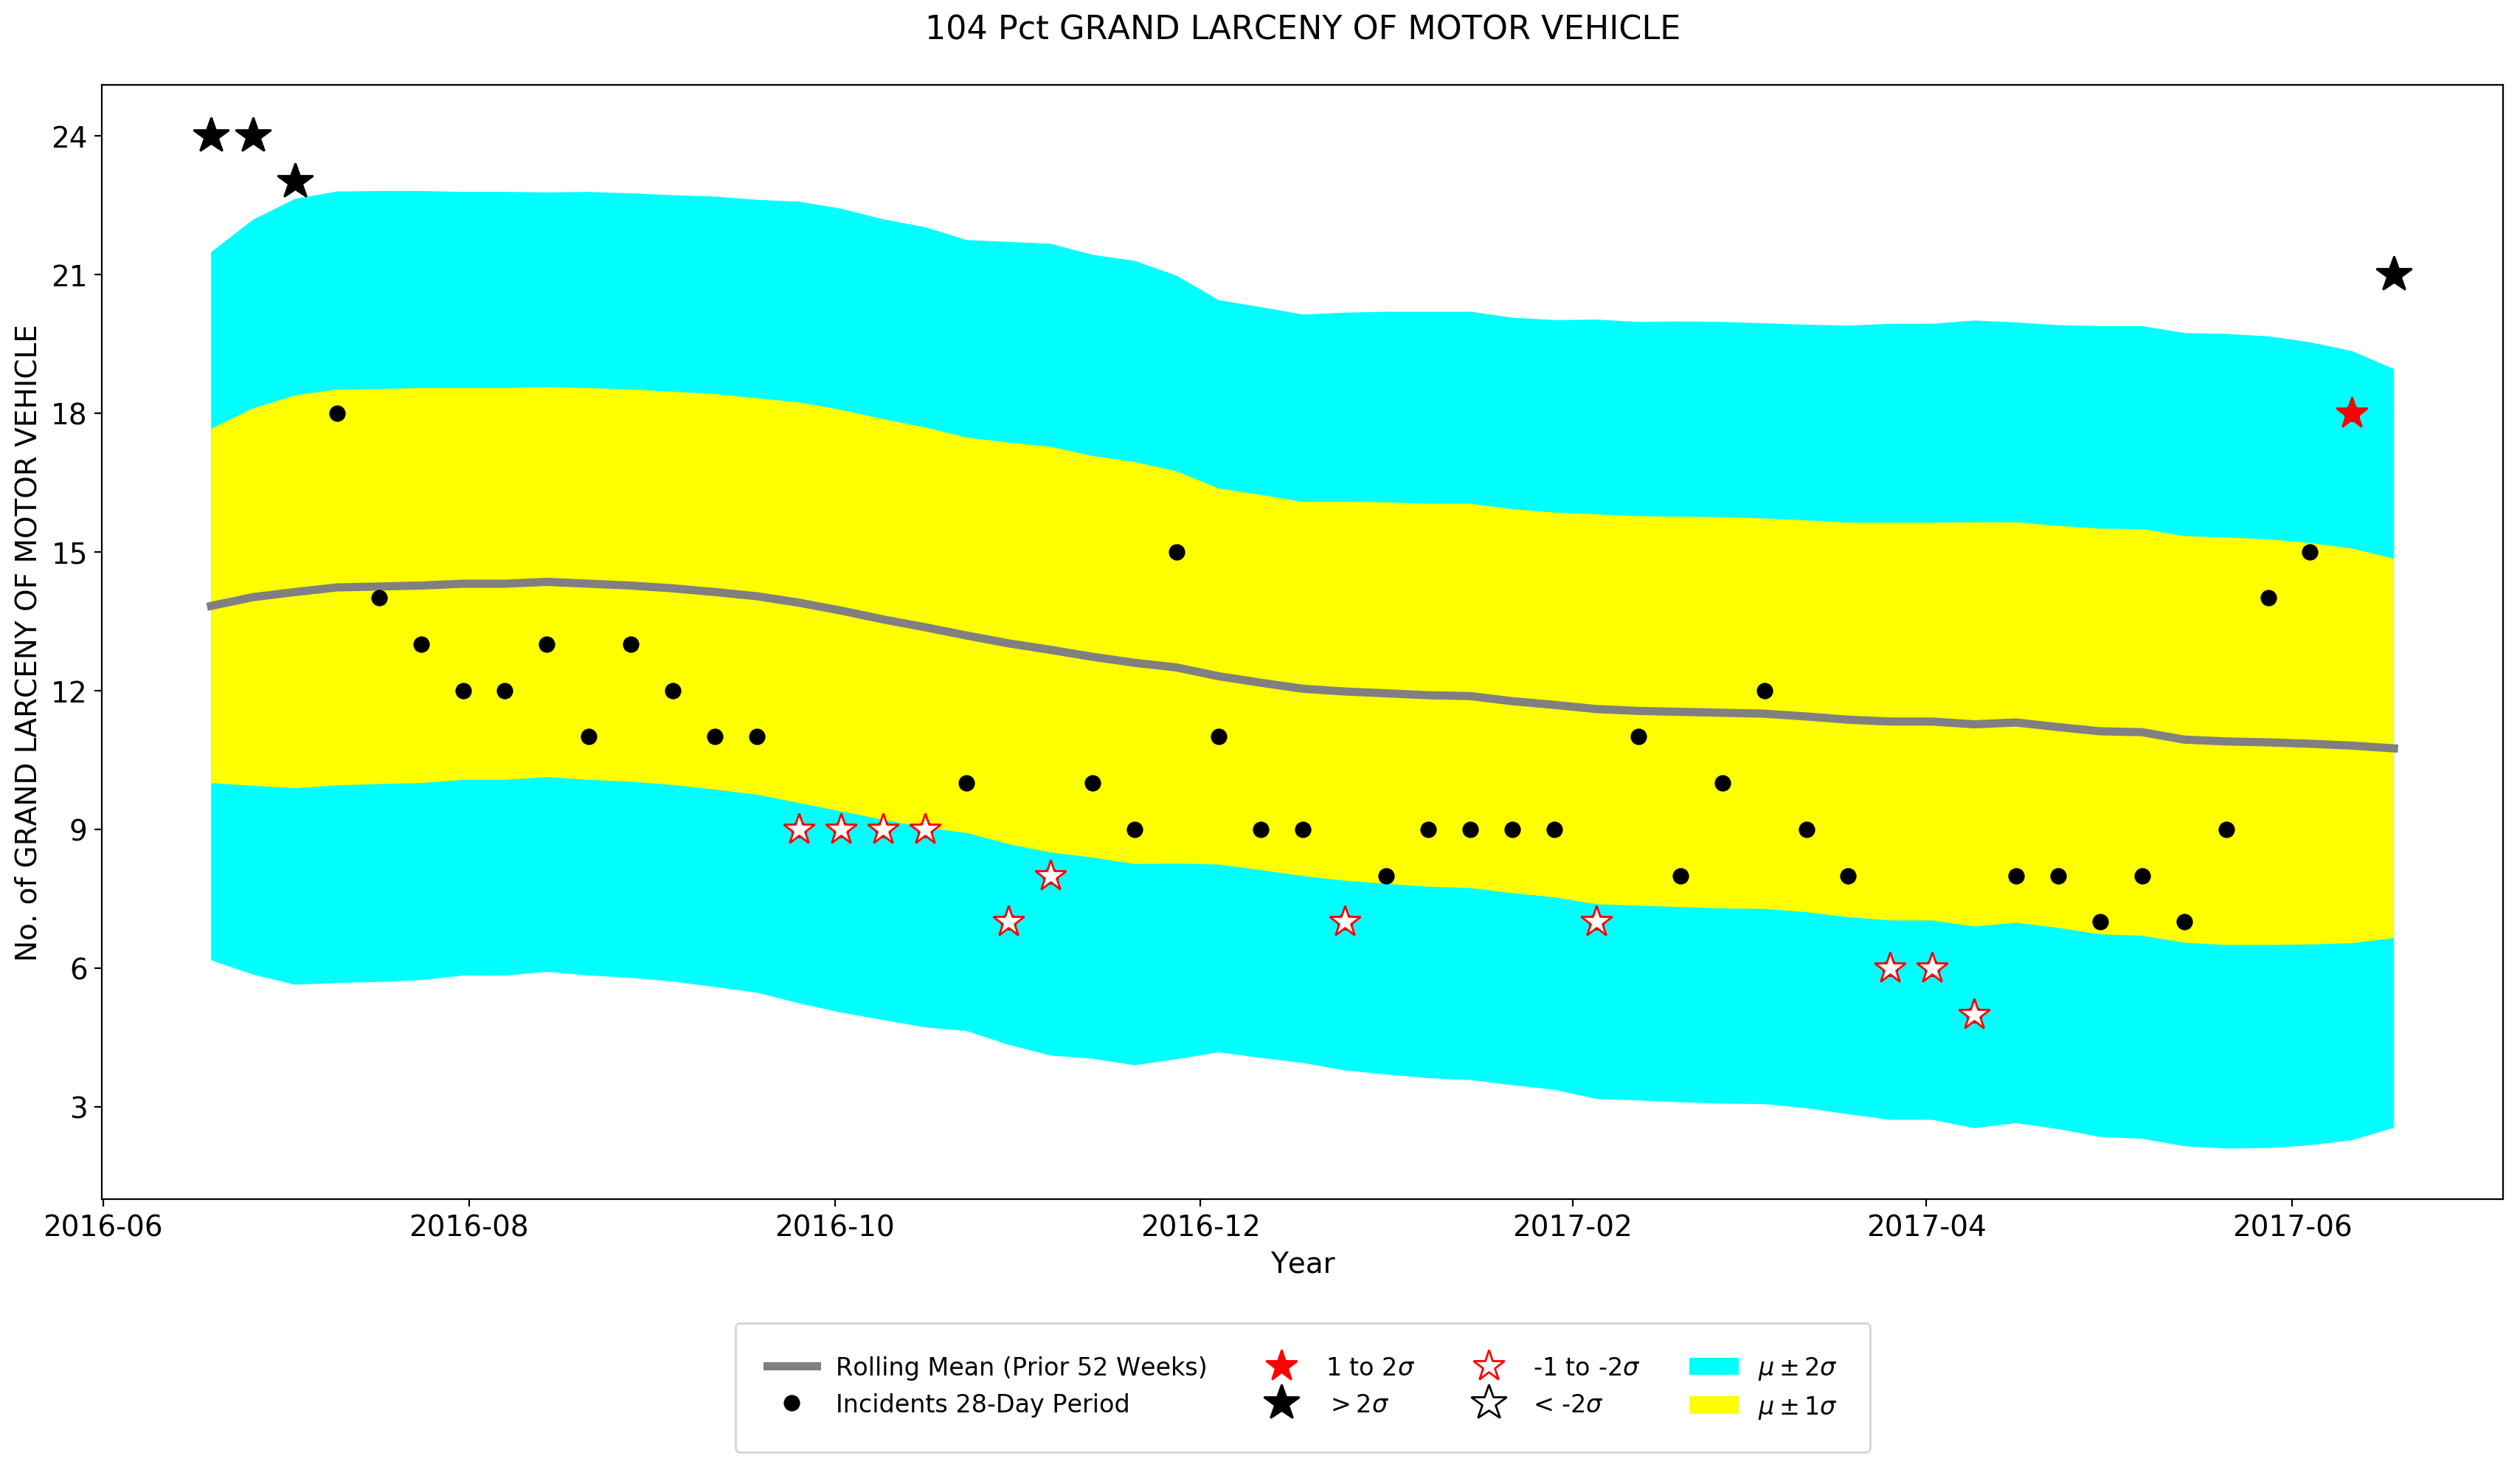

In [52]:
create_graph(incidents_f[(incidents_f.index.get_level_values('crime')=='GRAND LARCENY OF MOTOR VEHICLE') & 
                       (incidents_f.index.get_level_values('pct')==104)])

Generating graph for 45 PCT ASSAULT 3 & RELATED OFFENSES


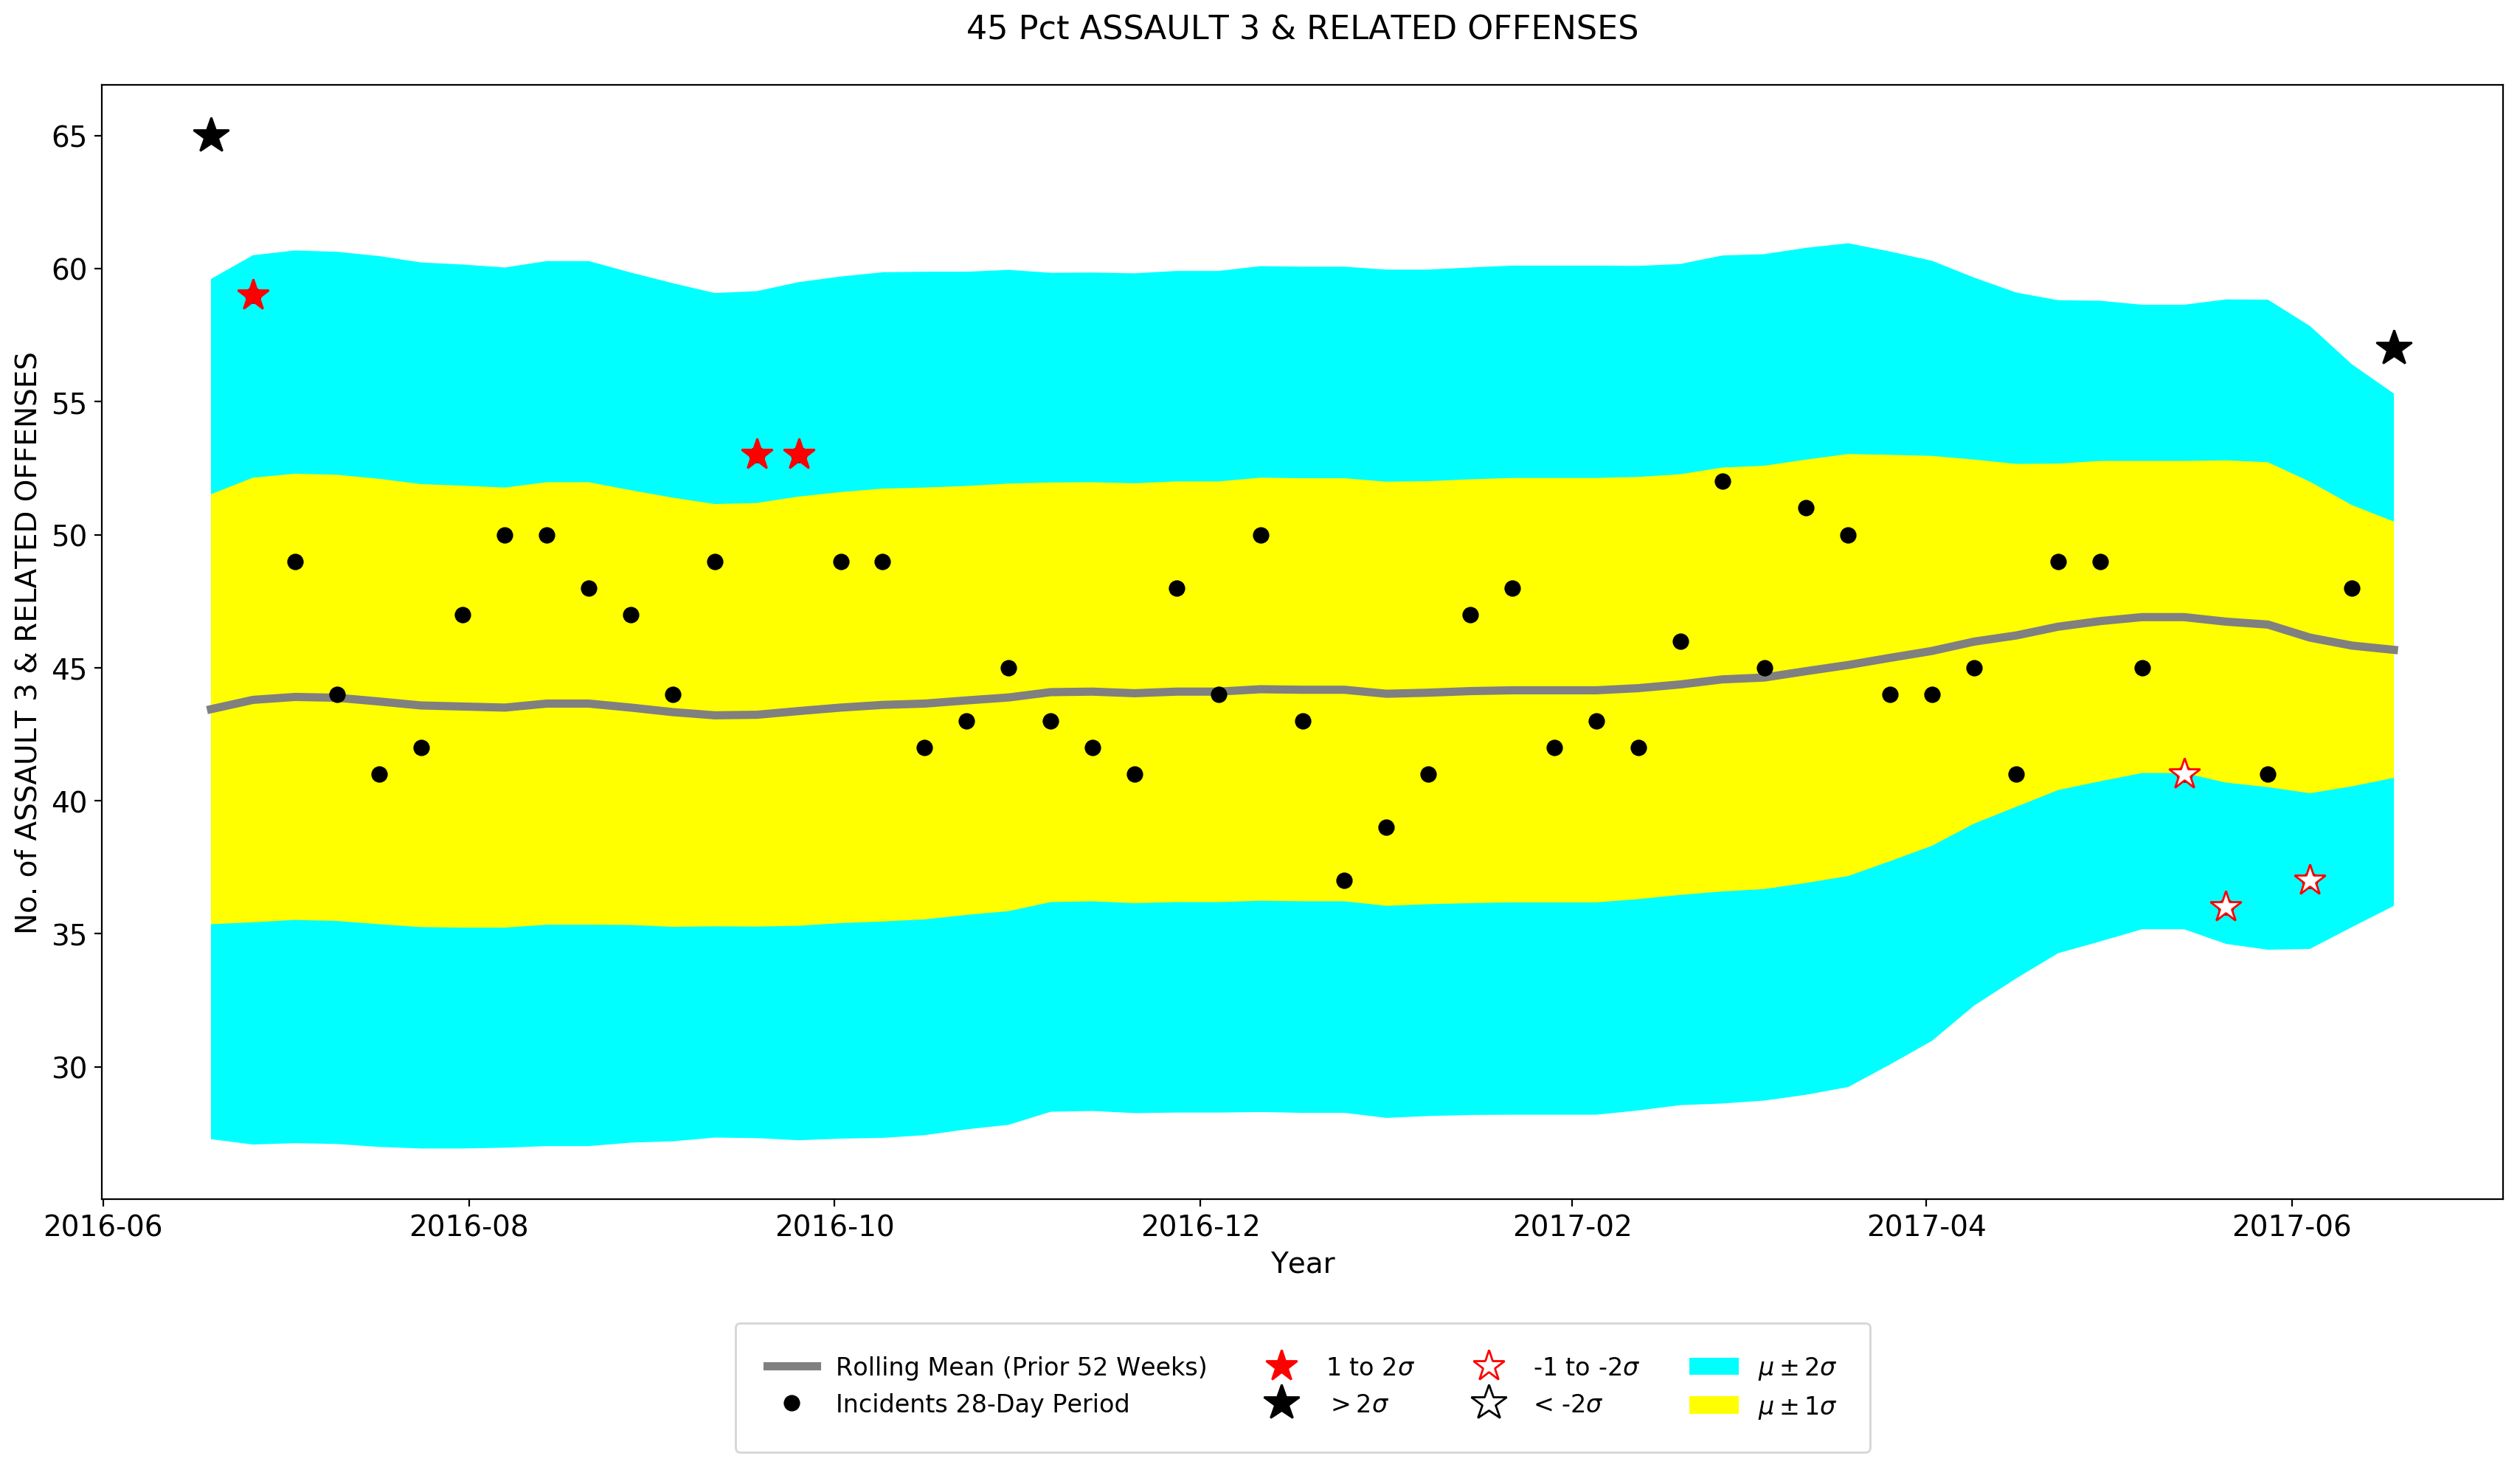

In [53]:
create_graph(incidents[(incidents.index.get_level_values('crime')=='ASSAULT 3 & RELATED OFFENSES') & 
                       (incidents.index.get_level_values('pct')==45)])